In [1]:
%load_ext rpy2.ipython
from functools import lru_cache

import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

from datasets import Boyd2019, MultiCellDataset
from losses import ContrastiveLoss
from networks import SiameseNet
from viz import get_embedding, xy_plot


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

results_path = 'results/boyd_2019/'
metadata_file = 'data/boyd_2019_PlateMap-KPP_MOA.xlsx'

In [2]:
%%R -i results_path

library(tidyverse)

sn <- lapply(list.files(path = results_path, pattern = '*tsv'), function(f) {
    
    params <- strsplit(f, '_') %>% unlist
    
    read_tsv(paste0(results_path, f), col_types = 'dd') %>%
        mutate(dropout = as.numeric(params[3]),
               margin = as.numeric(params[5]),
               seed = strsplit(params[7], '.', fixed = TRUE) %>% unlist %>% head(1) %>% as.numeric,
               i = 1:n()) %>%
        filter(i %% 1000 == 0)
    
}) %>% bind_rows %>%
    pivot_longer(ends_with('loss'), names_to = 'dataset', values_to = 'loss') %>%
    mutate(dataset = gsub('_loss', '', dataset))

R[write to console]: ── Attaching packages ────────────────────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ───────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



`summarise()` has grouped output by 'dropout', 'margin', 'dataset'. You can override using the `.groups` argument.


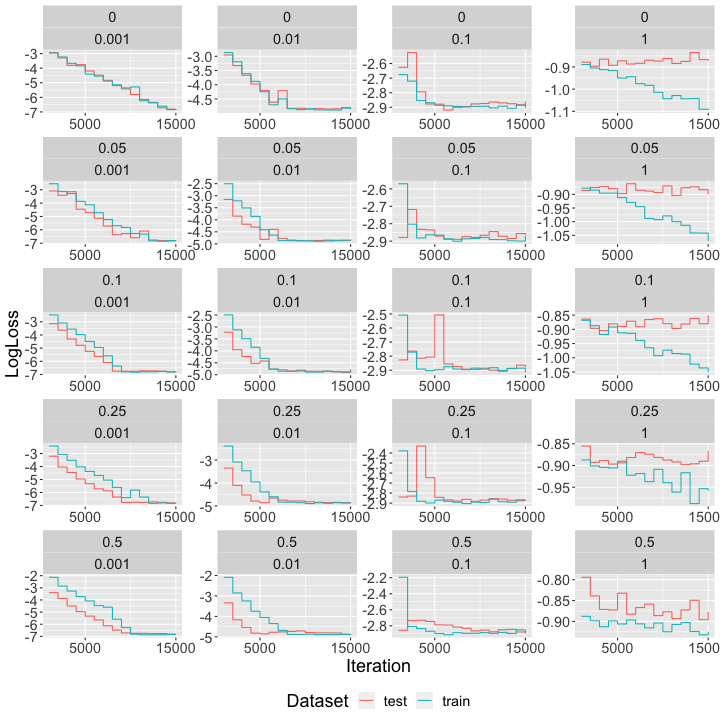

In [3]:
%%R -w 10 -h 10 --units in

sn %>%
    group_by(dropout, margin, dataset, i) %>%
    summarize(loss = mean(loss)) %>%
    ggplot(aes(x=i, y=log10(loss), color=dataset)) +
        geom_step() +
        facet_wrap(dropout ~ margin, scales = 'free', ncol=4) +
        labs(x = 'Iteration', y='LogLoss', color='Dataset') +
        scale_x_continuous(breaks = c(1, 5000, 15000)) +
        theme(text = element_text(size=18),
              legend.position = 'bottom')

In [14]:
@lru_cache(maxsize=None)
def get_embeddings(dropout, margin, seed, dataset='test'):

    torch_file = 'sn_dropout_%s_margin_%s_seed_%s_epoch_090.torch' %\
        (dropout, margin, seed)

    # load saved net
    net = SiameseNet().to(device)
    net.load_state_dict(torch.load(results_path + torch_file,
                                   map_location=torch.device(device)))
    net = net.eval()

    # get test set: different wells than training
    metadata = Boyd2019.read_metadata('data/boyd_2019_PlateMap-KPP_MOA.xlsx')
    metadata = metadata.loc[metadata.moa.isin(['Neutral', 'PKC Inhibitor'])]

    ds1 = torch.load('%s/%s_1_%s.pkl' % (results_path, dataset, seed))
    ds2 = torch.load('%s/%s_2_%s.pkl' % (results_path, dataset, seed))
    te_boyd2019 = MultiCellDataset(ds1, ds2, metadata)

    te_dataloader = DataLoader(te_boyd2019,
                                 shuffle=True,
                                 num_workers=8,
                                 batch_size=64)

    # sample test set
    embedding = np.empty((0,256))
    moas = []
    cell_line = np.empty((0,))

    for i, data in enumerate(te_dataloader,0):
        img0, moa0, img1, moa1, _ = data
        img0, img1 = img0.to(device), img1.to(device)
        output1,output2 = net(img0,img1)

        embedding = np.concatenate((embedding, output1.detach().numpy(), output2.detach().numpy()))
        cell_line = np.concatenate((cell_line,
                                    np.repeat('mda468', output1.shape[0]),
                                    np.repeat('mda231', output2.shape[0])))
        moas.extend(moa0)
        moas.extend(moa1)

        if i == 100:
            break

    return get_embedding(embedding, 'umap'), moas, cell_line

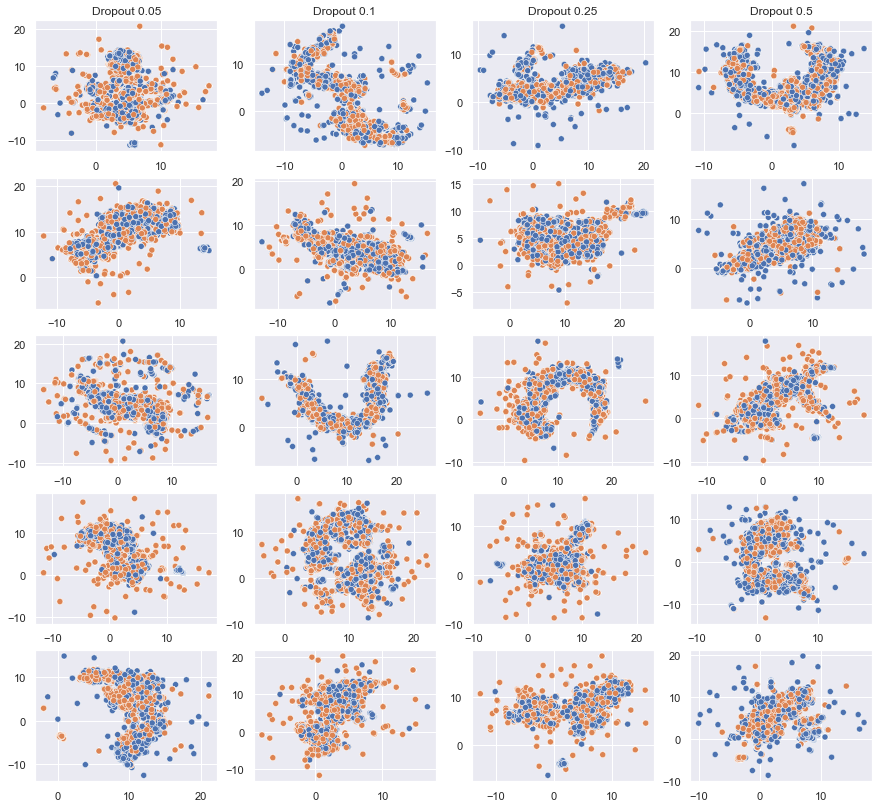

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

dropouts = [0.05, 0.1, 0.25, 0.5]
fig, ax = plt.subplots(5, len(dropouts), figsize = (15, 14))

np.random.seed(1)

for i in range(5):
    for j,d in enumerate(dropouts):

        x, moa, cell_line = get_embeddings(d, 0.001, i+1, 'test')
        sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=moa, ax=ax[i,j])
        ax[i,j].get_legend().remove()
        if i == 0:
            ax[i,j].title.set_text('Dropout %s' % d)

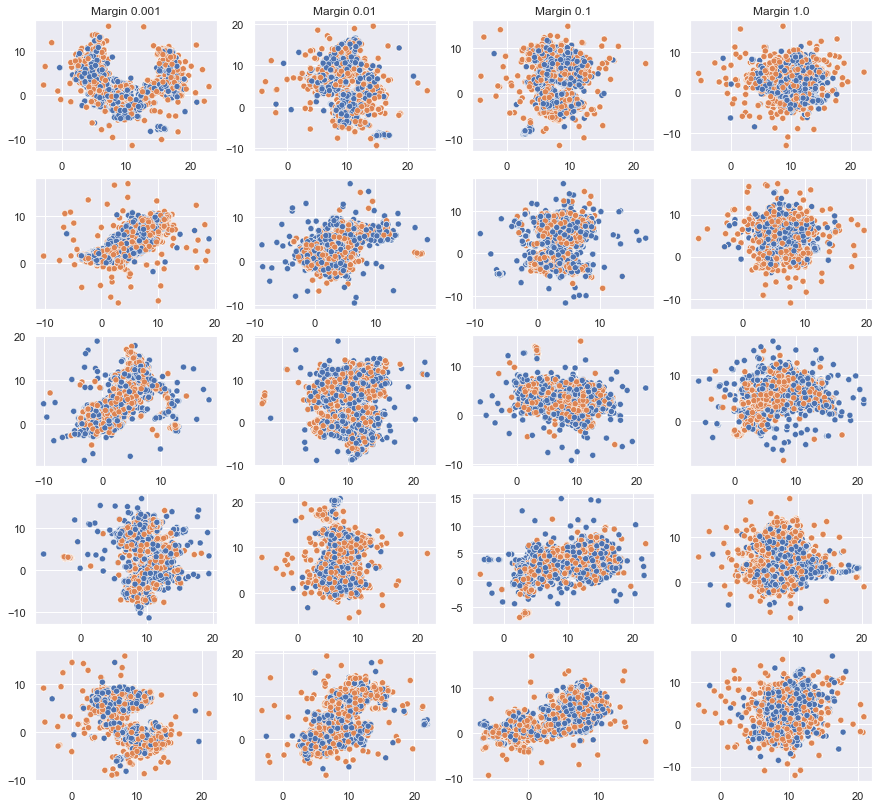

In [16]:
margins = ['0.001', '0.01', '0.1', '1.0']
fig, ax = plt.subplots(5, len(margins), figsize = (15, 14))

for i in range(5):
    for j,m in enumerate(margins):

        x, moa, cell_line = get_embeddings(0.5, m, i+1, 'test')
        sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=moa, ax=ax[i,j])
        ax[i,j].get_legend().remove()
        if i == 0:
            ax[i,j].title.set_text('Margin %s' % m)

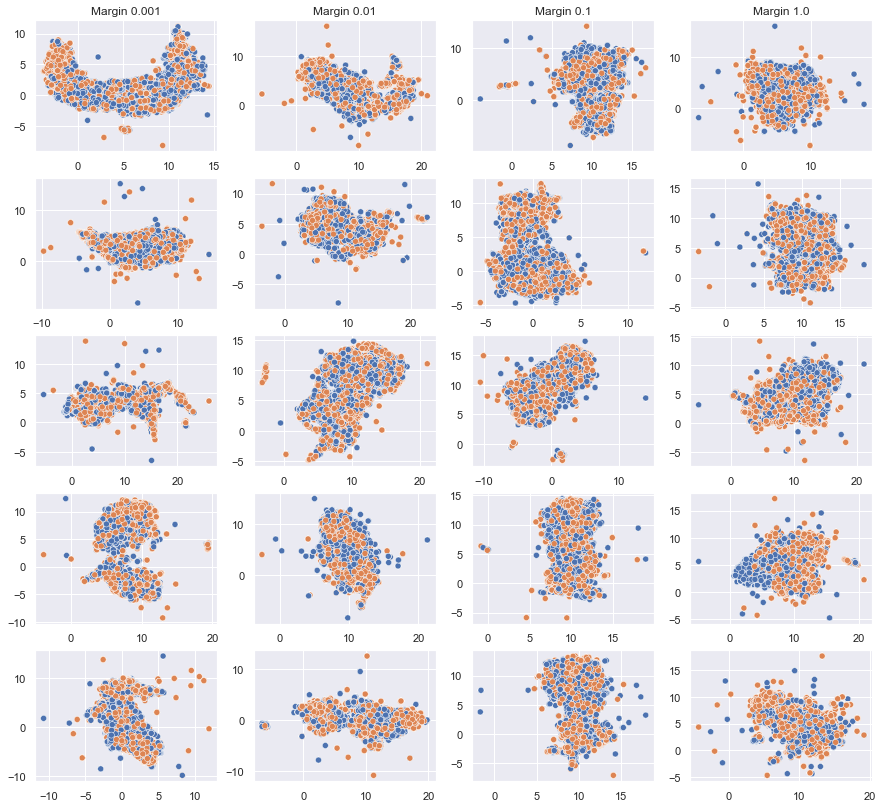

In [17]:
margins = ['0.001', '0.01', '0.1', '1.0']
fig, ax = plt.subplots(5, len(margins), figsize = (15, 14))

for i in range(5):
    for j,m in enumerate(margins):

        x, moa, cell_line = get_embeddings(0.5, m, i+1, 'train')
        sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=cell_line, ax=ax[i,j])
        ax[i,j].get_legend().remove()
        if i == 0:
            ax[i,j].title.set_text('Margin %s' % m)